<a href="https://colab.research.google.com/github/suvadityamuk/Temporal-Latent-Bottleneck-TF/blob/main/notebooks/attention_scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install -q tensorflow==2.11.0

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.experimental import AdamW
from typing import Tuple
from matplotlib import pyplot as plt

# Set seed for reproducibility.
tf.keras.utils.set_random_seed(42)

In [3]:
print(tf.__version__)

2.11.0


# Configurations

In [4]:
# DATA
TRAIN_SLICE = 40000
BATCH_SIZE = 512
BUFFER_SIZE = BATCH_SIZE*2
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
IMAGE_SIZE = 48
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# TRAINING
EPOCHS = 10

# MODEL
PATCH_SIZE = 4
EMBED_DIM = 64
CHUNK_SIZE = 8
R = 2
NUM_LAYERS = 4
FFN_DROP = 0.1
ATTN_DROP = 0.1
NUM_HEADS = 1

# Datasets

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:TRAIN_SLICE], y_train[:TRAIN_SLICE]),
    (x_train[TRAIN_SLICE:], y_train[TRAIN_SLICE:]),
)

170498071/170498071 [==============================] - 2s 0us/step


In [6]:
# Build the `train` augmentation pipeline.
train_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0),
        layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
        layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
    ],
    name="train_data_augmentation",
)

# Build the `val` and `test` data pipeline.
test_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    ],
    name="test_data_augmentation",
)

In [7]:
def train_map_fn(image, label):
    return train_aug(image), label

def test_map_fn(image, label):
    return test_aug(image), label

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds.map(
        train_map_fn, num_parallel_calls=AUTO
    )
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = (
    val_ds.map(
        test_map_fn, num_parallel_calls=AUTO
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds.map(
        test_map_fn, num_parallel_calls=AUTO
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [9]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label.shape)

(512, 48, 48, 3)
(512, 1)


# PatchEmbedding

In [10]:
class PatchEmbed(layers.Layer):
    """Image patch embedding layer.

    Args:
        image_size (Tuple[int]): Input image resolution.
        patch_size (Tuple[int]): Patch spatial resolution.
        embed_dim (int): Embedding dimension.
        add_pos_info (bool): Whether to add positional information to tokens.
    """

    def __init__(
        self,
        image_size: Tuple[int] = (48, 48),
        patch_size: Tuple[int] = (4, 4),
        embed_dim: int = 32,
        chunk_size: int = 8,
        **kwargs,
    ):
        super().__init__(**kwargs)
        patch_resolution = [
            image_size[0] // patch_size[0],
            image_size[1] // patch_size[1],
        ]
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_resolution = patch_resolution
        self.num_patches = patch_resolution[0] * patch_resolution[1]
        self.proj = layers.Conv2D(
            filters=embed_dim, kernel_size=patch_size, strides=patch_size
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=embed_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)
        self.norm = keras.layers.LayerNormalization(epsilon=1e-5)
        self.chunking_layer = layers.Reshape(
            target_shape=(self.num_patches//chunk_size, chunk_size, embed_dim)
        )

    def call(self, x: tf.Tensor) -> Tuple[tf.Tensor, int, int, int]:
        """Patchifies the image, converts into tokens and adds pos information.

        Args:
            x: Tensor of shape (B, H, W, C)

        Returns:
            A tuple of the processed tensor, height of the projected
            feature map, width of the projected feature map, number
            of channels of the projected feature map.
        """
        # Project the inputs.
        x = self.proj(x)
        x = self.flatten(x)
        x = x + self.position_embedding(self.positions)

        # B, H, W, C -> B, H*W, C
        x = self.norm(x)

        # Chunk the tokens in K
        x = self.chunking_layer(x)

        return x

# FFN

In [11]:
class FeedForwardNetwork(layers.Layer):
    """Feed Forward Network.

    Args:
        dims (`int`): Dimension of the FFN.
        dropout (`float`): Dropout probability of FFN.
    """

    def __init__(self, dims: int, dropout: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.ffn = keras.Sequential(
            [
                layers.Dense(units=4*dims, activation=tf.nn.gelu),
                layers.Dense(units=dims),
                layers.Dropout(rate=dropout),
            ]
        )
        self.add = layers.Add()
        self.layernorm = layers.LayerNormalization(epsilon=1e-5)

    def call(self, inputs: tf.Tensor):
        x = self.layernorm(inputs)
        x = self.add([inputs, self.ffn(x)])
        return x

# Attention

In [12]:
class Attention(layers.Layer):
    """The base attention module.
    
    Args:
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        dropout (`float`): Dropout probability for Attention Module.
    
    """

    def __init__(self, num_heads: int, key_dim: int, dropout: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)
        self.q_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.k_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.v_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.add = layers.Add()

    def call(self, input_query: tf.Tensor, key: tf.Tensor, value: tf.Tensor):
        query = self.q_layernorm(input_query)
        key = self.k_layernorm(key)
        value = self.v_layernorm(value)
        (attn_outs, attn_scores) = self.mha(
            query=query,
            key=key,
            value=value,
            return_attention_scores=True,
        )
        self.attn_scores = attn_scores
        x = self.add([input_query, attn_outs])
        return x

In [13]:
class AttentionWithFFN(layers.Layer):
    """Self-attention module with FFN

    Args:
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        attn_dropout (`float`): Dropout probability for attention module.
    """

    def __init__(
        self,
        ffn_dims: int = 128,
        ffn_dropout: float = 0.1, 
        num_heads: int = 4,
        key_dim: int = 256,
        attn_dropout: float = 0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.attention = Attention(num_heads, key_dim, attn_dropout)
        self.ffn = FeedForwardNetwork(ffn_dims, ffn_dropout)
        
    
    def call(self, query: tf.Tensor, key: tf.Tensor, value: tf.Tensor):
        x = self.attention(query, key, value)
        self.attn_scores = self.attention.attn_scores
        x = self.ffn(x)
        return x

# Recurrence

In [14]:
class CustomCell(layers.Layer):
    """Custom logic inside each recurrence.

    Args:
        chunk_size (`int`): Chunk size of the inputs.
        r (`int`): One Cross Attention per **r** Self Attention.
        num_layers (`int`): Number of layers in the Perceptual Model.
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        attn_dropout (`float`): Dropout probability for attention module.
    """
    def __init__(
        self,
        chunk_size,
        r=2,
        num_layers: int = 5,
        ffn_dims: int = 128,
        ffn_dropout: float = 0.1, 
        num_heads: int = 4,
        key_dim: int = 256,
        attn_dropout: float = 0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.chunk_size = chunk_size
        self.r = r
        self.num_layers = num_layers
        self.ffn_dims = ffn_dims
        self.ffn_droput = ffn_dropout
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attn_dropout = attn_dropout

        self.state_size = tf.TensorShape([chunk_size, ffn_dims])
        self.output_size = tf.TensorShape([chunk_size, ffn_dims])

        self.get_attn_scores = False
        self.attn_scores = []

        ########################################################################
        # Perceptual Module
        ########################################################################
        perceptual_module = list()
        for layer_idx in range(num_layers):
            perceptual_module.append(
                AttentionWithFFN(
                    ffn_dims=ffn_dims,
                    ffn_dropout=ffn_dropout, 
                    num_heads=num_heads,
                    key_dim=key_dim,
                    attn_dropout=attn_dropout,
                    name=f"PM_SelfAttentionFFN{layer_idx}")
            )
            if layer_idx % r == 0:
                perceptual_module.append(
                    AttentionWithFFN(
                    ffn_dims=ffn_dims,
                    ffn_dropout=ffn_dropout, 
                    num_heads=num_heads,
                    key_dim=key_dim,
                    attn_dropout=attn_dropout,
                    name=f"PM_CrossAttentionFFN{layer_idx}")
                )
        self.perceptual_module = perceptual_module

        ########################################################################
        # Temporal Latent Bottleneck Module
        ########################################################################
        self.tlb_module = AttentionWithFFN(
            ffn_dims=ffn_dims,
            ffn_dropout=ffn_dropout, 
            num_heads=num_heads,
            key_dim=key_dim,
            attn_dropout=attn_dropout,
            name=f"TLBM_CrossAttentionFFN"
        )

    def call(self, inputs, states, training=None):
        # inputs => (batch, chunk_size, dims)
        # states => [(batch, chunk_size, units)]

        slow_stream = states[0]
        fast_stream = inputs

        for layer_idx, layer in enumerate(self.perceptual_module):
            fast_stream = layer(
                query=fast_stream,
                key=fast_stream,
                value=fast_stream
            )
            
            if layer_idx % self.r == 0:
                fast_stream = layer(
                    query=fast_stream,
                    key=slow_stream,
                    value=slow_stream
                )
        
        slow_stream = self.tlb_module(
            query=slow_stream,
            key=fast_stream,
            value=fast_stream
        )

        if self.get_attn_scores:
            self.attn_scores.append(self.tlb_module.attn_scores)
        
        return fast_stream, [slow_stream]

# Build the model

In [15]:
class ModelTrainer(keras.Model):
    def __init__(self, patch_layer, custom_cell, **kwargs):
        super().__init__(**kwargs)
        self.patch_layer = patch_layer
        self.rnn = layers.RNN(custom_cell)
        self.gap = layers.GlobalAveragePooling1D()
        self.head = layers.Dense(10, activation="softmax")
    
    def call(self, inputs):
        x = self.patch_layer(inputs)
        x = self.rnn(x)
        x = self.gap(x)
        outputs = self.head(x)
        return outputs

In [16]:
keras.backend.clear_session()

# PATCH
patch_layer = PatchEmbed(
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    patch_size=(PATCH_SIZE, PATCH_SIZE),
    embed_dim=EMBED_DIM,
    chunk_size=CHUNK_SIZE,
)

# RECURRENCE
cell = CustomCell(
    chunk_size=CHUNK_SIZE,
    r=R,
    num_layers=NUM_LAYERS,
    ffn_dims=EMBED_DIM,
    ffn_dropout=FFN_DROP, 
    num_heads=NUM_HEADS,
    key_dim=EMBED_DIM,
    attn_dropout=ATTN_DROP,
)


model = ModelTrainer(patch_layer, cell)

In [17]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

In [18]:
# optimizer = AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)

# Compile and train the model.
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    # jit_compile=True,
)
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
)

Epoch 1/10
79/79 [==============================] - 187s 1s/step - loss: 2.2677 - accuracy: 0.1657 - val_loss: 2.0770 - val_accuracy: 0.2530
Epoch 2/10
79/79 [==============================] - 90s 1s/step - loss: 2.0327 - accuracy: 0.2517 - val_loss: 2.0299 - val_accuracy: 0.2691
Epoch 3/10
79/79 [==============================] - 90s 1s/step - loss: 1.9517 - accuracy: 0.2858 - val_loss: 1.9134 - val_accuracy: 0.3038
Epoch 4/10
79/79 [==============================] - 90s 1s/step - loss: 1.8583 - accuracy: 0.3239 - val_loss: 1.7946 - val_accuracy: 0.3482
Epoch 5/10
79/79 [==============================] - 90s 1s/step - loss: 1.7356 - accuracy: 0.3637 - val_loss: 1.6872 - val_accuracy: 0.3830
Epoch 6/10
79/79 [==============================] - 90s 1s/step - loss: 1.6478 - accuracy: 0.3935 - val_loss: 1.5868 - val_accuracy: 0.4210
Epoch 7/10
79/79 [==============================] - 90s 1s/step - loss: 1.5858 - accuracy: 0.4152 - val_loss: 1.5406 - val_accuracy: 0.4376
Epoch 8/10
79/79 [=

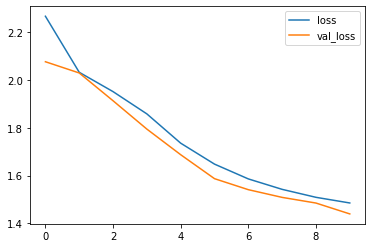

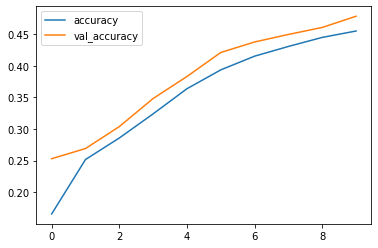

In [19]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

# Visualize the Latent Bottleneck

In [20]:
images, labels = next(iter(test_ds))

# Set the flag for attn score
model.rnn.cell.get_attn_scores = True
outputs = model(images)

In [21]:
# Grab the list of chunk scores
list_chunk_scores = model.rnn.cell.attn_scores

In [22]:
def score_to_viz(chunk_score):
    chunk_viz = tf.math.reduce_max(chunk_score, axis=-1) # get the most attended token
    chunk_viz = tf.math.reduce_mean(chunk_viz, axis=1) # get the mean across heads
    return chunk_viz

In [23]:
list_chunk_viz = [score_to_viz(x) for x in list_chunk_scores]

In [24]:
chunk_viz = tf.concat(list_chunk_viz[1:], axis=-1)
chunk_viz = tf.reshape(
    chunk_viz,
    (BATCH_SIZE, IMAGE_SIZE//PATCH_SIZE, IMAGE_SIZE//PATCH_SIZE, 1)
)

In [25]:
upsampled_heat_map = layers.UpSampling2D(
    size=(4, 4),
    interpolation='bilinear'
)(chunk_viz)

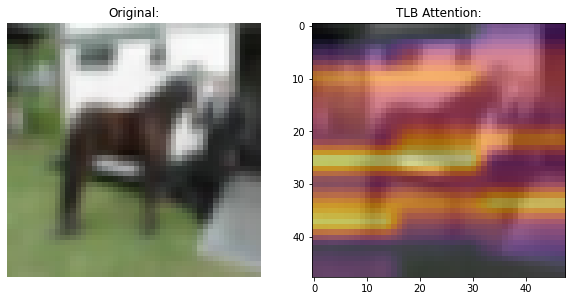

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

index = 20
orig_image = images[index]
overlay_image = upsampled_heat_map[index, ..., 0]

ax[0].imshow(orig_image)
ax[0].set_title("Original:")
ax[0].axis("off")

image = ax[1].imshow(orig_image)
ax[1].imshow(
    overlay_image,
    cmap="inferno",
    alpha=0.6,
    extent=image.get_extent()
)
ax[1].set_title("TLB Attention:")

plt.show()